## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.25, 0.5, 0.7]
redice_lr_patient = [5, 10, 15]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                                  min_lr=1e-12, 
                                  monitor='val_loss', 
                                  patience=5, 
                                  verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["accuracy"],
                             'valid-acc': model.history.history["val_accuracy"]}

Numbers of exp: 0, reduce_factor: 0.25, reduce_patient: 5
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 920,842
Trainable params: 920,842
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/25


50000/50000 [==============================] - 1s 16us/step - loss: 1.6478 - accuracy: 0.4246 - val_loss: 1.6489 - val_accuracy: 0.4257
Epoch 17/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6351 - accuracy: 0.4289 - val_loss: 1.6347 - val_accuracy: 0.4271
Epoch 18/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.6230 - accuracy: 0.4333 - val_loss: 1.6254 - val_accuracy: 0.4293
Epoch 19/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6109 - accuracy: 0.4372 - val_loss: 1.6137 - val_accuracy: 0.4368
Epoch 20/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5996 - accuracy: 0.4406 - val_loss: 1.6045 - val_accuracy: 0.4352
Epoch 21/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5890 - accuracy: 0.4453 - val_loss: 1.5962 - val_accuracy: 0.4400
Epoch 22/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5781 - accuracy: 0.4487 - val_loss: 1.5869

50000/50000 [==============================] - 1s 16us/step - loss: 1.8470 - accuracy: 0.3515 - val_loss: 1.8355 - val_accuracy: 0.3582
Epoch 7/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.8198 - accuracy: 0.3608 - val_loss: 1.8099 - val_accuracy: 0.3647
Epoch 8/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.7956 - accuracy: 0.3706 - val_loss: 1.7876 - val_accuracy: 0.3745
Epoch 9/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.7737 - accuracy: 0.3788 - val_loss: 1.7660 - val_accuracy: 0.3828
Epoch 10/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.7534 - accuracy: 0.3865 - val_loss: 1.7476 - val_accuracy: 0.3882
Epoch 11/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.7354 - accuracy: 0.3909 - val_loss: 1.7298 - val_accuracy: 0.3915
Epoch 12/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.7180 - accuracy: 0.3986 - val_loss: 1.7140 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 1s 18us/step - loss: 2.2367 - accuracy: 0.1757 - val_loss: 2.1498 - val_accuracy: 0.2405
Epoch 2/25
50000/50000 [==============================] - 1s 17us/step - loss: 2.0810 - accuracy: 0.2629 - val_loss: 2.0169 - val_accuracy: 0.2920
Epoch 3/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.9702 - accuracy: 0.3075 - val_loss: 1.9301 - val_accuracy: 0.3227
Epoch 4/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.9003 - accuracy: 0.3330 - val_loss: 1.8786 - val_accuracy: 0.3398
Epoch 5/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.8554 - accuracy: 0.3511 - val_loss: 1.8405 - val_accuracy: 0.3591
Epoch 6/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.8228 - accuracy: 0.3624 - val_loss: 1.8135 - val_accuracy: 0.3697
Epoch 7/25
50000/50000 [==============================] - 1s 17us/st

50000/50000 [==============================] - 1s 16us/step - loss: 1.5787 - accuracy: 0.4497 - val_loss: 1.5848 - val_accuracy: 0.4473
Epoch 24/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5703 - accuracy: 0.4516 - val_loss: 1.5768 - val_accuracy: 0.4517
Epoch 25/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5621 - accuracy: 0.4539 - val_loss: 1.5703 - val_accuracy: 0.4488
Numbers of exp: 7, reduce_factor: 0.70, reduce_patient: 10
Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
______________________________

50000/50000 [==============================] - 1s 17us/step - loss: 1.7102 - accuracy: 0.4025 - val_loss: 1.7095 - val_accuracy: 0.3962
Epoch 14/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6969 - accuracy: 0.4063 - val_loss: 1.6943 - val_accuracy: 0.4051
Epoch 15/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6838 - accuracy: 0.4108 - val_loss: 1.6839 - val_accuracy: 0.4070
Epoch 16/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6718 - accuracy: 0.4160 - val_loss: 1.6726 - val_accuracy: 0.4145
Epoch 17/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6604 - accuracy: 0.4195 - val_loss: 1.6604 - val_accuracy: 0.4168
Epoch 18/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6492 - accuracy: 0.4231 - val_loss: 1.6503 - val_accuracy: 0.4205
Epoch 19/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6385 - accuracy: 0.4266 - val_loss: 1.6427

50000/50000 [==============================] - 1s 17us/step - loss: 1.7816 - accuracy: 0.3577 - val_loss: 1.7397 - val_accuracy: 0.3753
Epoch 4/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.7114 - accuracy: 0.3832 - val_loss: 1.6683 - val_accuracy: 0.4021
Epoch 5/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.6547 - accuracy: 0.4057 - val_loss: 1.6269 - val_accuracy: 0.4214
Epoch 6/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6327 - accuracy: 0.4137 - val_loss: 1.6270 - val_accuracy: 0.4239
Epoch 7/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.5906 - accuracy: 0.4284 - val_loss: 1.5858 - val_accuracy: 0.4343
Epoch 8/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5728 - accuracy: 0.4358 - val_loss: 1.5669 - val_accuracy: 0.4425
Epoch 9/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.5443 - accuracy: 0.4466 - val_loss: 1.5647 - val

Numbers of exp: 12, reduce_factor: 0.50, reduce_patient: 5
Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 920,842
Trainable params: 920,842
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/2

50000/50000 [==============================] - 1s 18us/step - loss: 1.4810 - accuracy: 0.4704 - val_loss: 1.5420 - val_accuracy: 0.4492
Epoch 17/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.4758 - accuracy: 0.4730 - val_loss: 1.5091 - val_accuracy: 0.4619
Epoch 18/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.4655 - accuracy: 0.4749 - val_loss: 1.5045 - val_accuracy: 0.4610
Epoch 19/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.4546 - accuracy: 0.4797 - val_loss: 1.4967 - val_accuracy: 0.4689
Epoch 20/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.4463 - accuracy: 0.4817 - val_loss: 1.4900 - val_accuracy: 0.4706
Epoch 21/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.4346 - accuracy: 0.4854 - val_loss: 1.4827 - val_accuracy: 0.4717
Epoch 22/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.4323 - accuracy: 0.4852 - val_loss: 1.4860

50000/50000 [==============================] - 1s 17us/step - loss: 1.6298 - accuracy: 0.4164 - val_loss: 1.6123 - val_accuracy: 0.4240
Epoch 7/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6090 - accuracy: 0.4230 - val_loss: 1.5935 - val_accuracy: 0.4281
Epoch 8/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5682 - accuracy: 0.4374 - val_loss: 1.5538 - val_accuracy: 0.4478
Epoch 9/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5460 - accuracy: 0.4460 - val_loss: 1.5592 - val_accuracy: 0.4441
Epoch 10/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5318 - accuracy: 0.4523 - val_loss: 1.5682 - val_accuracy: 0.4349
Epoch 11/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5101 - accuracy: 0.4618 - val_loss: 1.5176 - val_accuracy: 0.4584
Epoch 12/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.4908 - accuracy: 0.4698 - val_loss: 1.5064 - 

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 1s 21us/step - loss: 2.6174 - accuracy: 0.1779 - val_loss: 1.9720 - val_accuracy: 0.2783
Epoch 2/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.9096 - accuracy: 0.3051 - val_loss: 1.8572 - val_accuracy: 0.3369
Epoch 3/25
50000/50000 [==============================] - 1s 19us/step - loss: 1.8095 - accuracy: 0.3501 - val_loss: 1.7555 - val_accuracy: 0.3724
Epoch 4/25
50000/50000 [==============================] - 1s 21us/step - loss: 1.7367 - accuracy: 0.3755 - val_loss: 1.7067 - val_accuracy: 0.3797
Epoch 5/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.6843 - accuracy: 0.3944 - val_loss: 1.6853 - val_accuracy: 0.3929
Epoch 6/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.6540 - accuracy: 0.4081 - val_loss: 1.6245 - val_accuracy: 0.4180
Epoch 7/25
50000/50000 [==============================] - 1s 18us/st

50000/50000 [==============================] - 1s 17us/step - loss: 1.3610 - accuracy: 0.5173 - val_loss: 1.4519 - val_accuracy: 0.4890
Epoch 24/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3515 - accuracy: 0.5202 - val_loss: 1.4390 - val_accuracy: 0.4904
Epoch 25/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.3445 - accuracy: 0.5236 - val_loss: 1.4541 - val_accuracy: 0.4851
Numbers of exp: 19, reduce_factor: 0.25, reduce_patient: 10
Model: "model_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
____________________________

50000/50000 [==============================] - 1s 18us/step - loss: 1.6012 - accuracy: 0.4325 - val_loss: 1.6171 - val_accuracy: 0.4239
Epoch 14/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5829 - accuracy: 0.4350 - val_loss: 1.5408 - val_accuracy: 0.4518
Epoch 15/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.5687 - accuracy: 0.4452 - val_loss: 1.5764 - val_accuracy: 0.4430
Epoch 16/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5594 - accuracy: 0.4486 - val_loss: 1.5327 - val_accuracy: 0.4563
Epoch 17/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.5416 - accuracy: 0.4521 - val_loss: 1.5558 - val_accuracy: 0.4569
Epoch 18/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.5280 - accuracy: 0.4575 - val_loss: 1.4973 - val_accuracy: 0.4654
Epoch 19/25
50000/50000 [==============================] - 1s 18us/step - loss: 1.5159 - accuracy: 0.4630 - val_loss: 1.6175

Epoch 3/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.8749 - accuracy: 0.3399 - val_loss: 1.8719 - val_accuracy: 0.3413
Epoch 4/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.8321 - accuracy: 0.3567 - val_loss: 1.8196 - val_accuracy: 0.3537
Epoch 5/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.8014 - accuracy: 0.3628 - val_loss: 1.7637 - val_accuracy: 0.3807
Epoch 6/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.7711 - accuracy: 0.3760 - val_loss: 1.7488 - val_accuracy: 0.3864
Epoch 7/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.7513 - accuracy: 0.3832 - val_loss: 1.7232 - val_accuracy: 0.3956
Epoch 8/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.7266 - accuracy: 0.3938 - val_loss: 1.7116 - val_accuracy: 0.3981
Epoch 9/25
50000/50000 [==============================] - 1s 17us/step - loss: 1.7081 - accuracy: 0.4007 - val_loss: 1

Numbers of exp: 24, reduce_factor: 0.70, reduce_patient: 5
Model: "model_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
output (Dense)               (None, 10)                2570      
Total params: 920,842
Trainable params: 920,842
Non-trainable params: 0
_________________________________________________________________
Train on 50000 samples, validate on 10000 samples
Epoch 1/2

50000/50000 [==============================] - 1s 16us/step - loss: 1.6127 - accuracy: 0.4355 - val_loss: 1.5973 - val_accuracy: 0.4377
Epoch 17/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.6001 - accuracy: 0.4384 - val_loss: 1.5978 - val_accuracy: 0.4381
Epoch 18/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5938 - accuracy: 0.4405 - val_loss: 1.6280 - val_accuracy: 0.4250
Epoch 19/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5837 - accuracy: 0.4468 - val_loss: 1.5876 - val_accuracy: 0.4390
Epoch 20/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5764 - accuracy: 0.4464 - val_loss: 1.5845 - val_accuracy: 0.4409
Epoch 21/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5650 - accuracy: 0.4508 - val_loss: 1.5825 - val_accuracy: 0.4444
Epoch 22/25
50000/50000 [==============================] - 1s 16us/step - loss: 1.5586 - accuracy: 0.4504 - val_loss: 1.5613

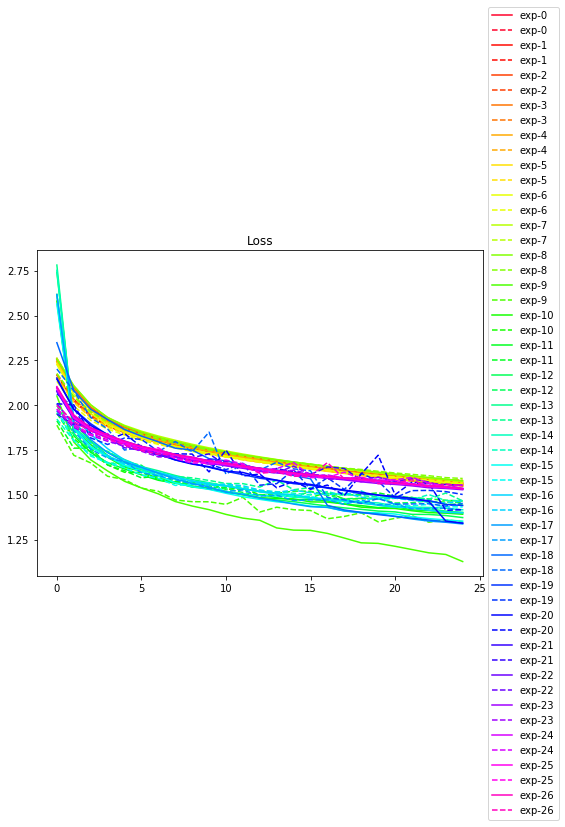

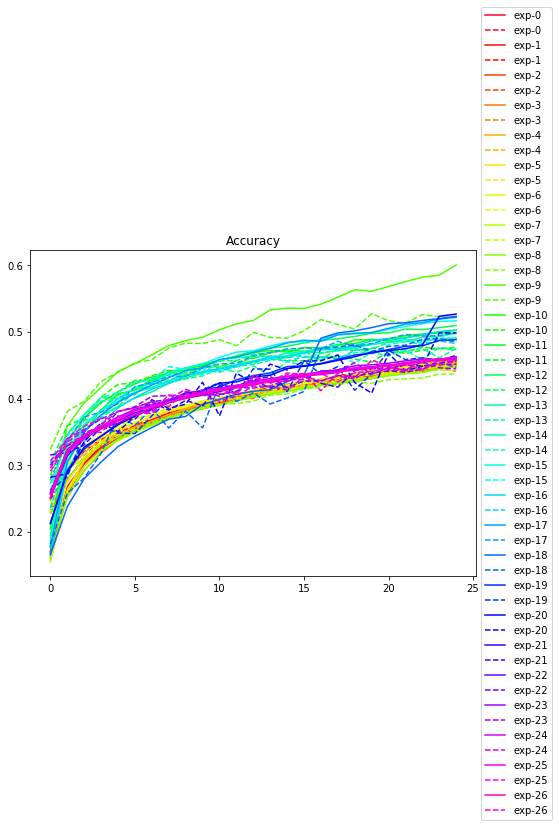

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()